###  Metro Traffic Volume Prediction Pipeline
#### 1. Imports and Configuration

In [1]:
# Core Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib # For saving/loading models
import time
import sys
import os

# Scikit-learn Preprocessing & Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin # For custom transformers

# Scikit-learn Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR


# Scikit-learn Metrics
from sklearn.metrics import mean_squared_error, r2_score

# Other Encoders
from category_encoders import TargetEncoder # For Target Encoding

# Configure display options (optional)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', 50) # Adjusted for better display
np.random.seed(42) # For reproducibility
plt.rcParams['figure.figsize'] = (12, 7) # Default figure size
sns.set_style("whitegrid")

print("✅ All necessary libraries imported.")

✅ All necessary libraries imported.


#### 2. Data Loading

In [2]:
data_file_path = '../data/Metro_Interstate_Traffic_Volume.csv'

#(
#    '/home/me/Work/Python/Projet_Python_Traffic/data/'
#    'Metro_Interstate_Traffic_Volume.csv'
#)
try:
    df = pd.read_csv(data_file_path)
    print(f"✅ Dataset chargé avec succès depuis: {data_file_path}")
except FileNotFoundError:
    print(
        f"❌ Erreur: Fichier non trouvé. "
        f"Vérifiez le chemin: {data_file_path}"
    )

✅ Dataset chargé avec succès depuis: ../data/Metro_Interstate_Traffic_Volume.csv


#### 3. Data Preprocessing

In [3]:
# Convert datetime and extract features
df['date_time'] = pd.to_datetime(df['date_time'], format="%d-%m-%Y %H:%M")
df['hour'] = df['date_time'].dt.hour
df['day_of_week'] = df['date_time'].dt.dayofweek
df['month'] = df['date_time'].dt.month
df['year'] = df['date_time'].dt.year

# Temperature conversion (Kelvin to Celsius)
df['temp'] = df['temp'] - 273.15

# Cleanup unnecessary columns
df = df.drop(columns=['date_time', 'weather_description'])

#### 4. Feature Engineering

In [4]:
# Temporal features
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

def get_peak_hour(hour):
    return (
        'morning_peak' if 7 <= hour < 10 else
        'evening_peak' if 16 <= hour < 19 else
        'off_peak'
    )

df['peak_hour'] = df['hour'].apply(get_peak_hour)

# Seasonal features
df['season'] = df['month'].apply(lambda m: 'winter' if m in [12,1,2] else 
                                 'spring' if m in [3,4,5] else
                                 'summer' if m in [6,7,8] else 'autumn')

# Weather features
df['precipitation'] = df['rain_1h'] + df['snow_1h']
df['is_precipitating'] = (df['precipitation'] > 0).astype(int)
df = df.drop(columns=['precipitation'])

# Temperature categories
df['temp_category'] = pd.cut(df['temp'],
                            bins=[-np.inf, 0, 15, 25, np.inf],
                            labels=['freezing', 'cold', 'mild', 'hot'])


#### 5. Custom Encoders

In [5]:
# Get the absolute path to the directory containing the notebook'
# For now, assuming the working directory IS the 'notebooks' folder when run:

project_root = os.path.abspath('..') # Go one level up to the project root

# Add the project root to the Python path if it's not already there
if project_root not in sys.path:
    sys.path.insert(0, project_root)
    print(f"Added project root to sys.path: {project_root}")

# Now the import should work
try:
    from src.custom_transformers import FrequencyEncoder
    print(
        "✅ FrequencyEncoder class imported successfully "
        "from src/custom_transformers.py"
    )
except ModuleNotFoundError:
    print(
        "❌ ERROR: Still cannot find 'src'. Check the project structure "
        "and path logic."
    )
except ImportError as e:
    print(f"❌ ERROR importing FrequencyEncoder: {e}")


✅ FrequencyEncoder class imported successfully from src/custom_transformers.py


#### 6. Pipeline Construction

In [ ]:
# Define feature types
numeric_features = ['temp', 'rain_1h', 'snow_1h', 'clouds_all']
categorical_ohe = ['holiday', 'weather_main']
categorical_target = ['peak_hour']
categorical_freq = ['season', 'temp_category']
# Remaining features ('hour', 'day_of_week', 'month', 'year',
# 'is_weekend', 'is_precipitating') will pass through via remainder='passthrough'

# Preprocessing pipeline definition
# Applies specific transformations to different column types
preprocessor = ColumnTransformer(
    transformers=[
        # Scale numeric features
        ('num', StandardScaler(), numeric_features),
        # One-hot encode low-cardinality categorical features
        ('ohe',
         OneHotEncoder(handle_unknown='ignore', sparse_output=False),
         categorical_ohe),
        # Target encode high-cardinality/potentially predictive categorical features
        ('target',
         TargetEncoder(cols=categorical_target,
                       handle_missing='value',
                       handle_unknown='value'),
         categorical_target),
        # Frequency encode other categorical features
        ('freq',
         FrequencyEncoder(cols=categorical_freq),
         categorical_freq)
    ],
    # Keep other columns not specified in transformers
    remainder='passthrough'
)

# Define models to be evaluated
models = {
    'RandomForest': RandomForestRegressor(
        n_estimators=200, max_depth=15, n_jobs=-1, random_state=42
    ), # Added random_state for reproducibility
    'GradientBoosting': GradientBoostingRegressor(
        n_estimators=100, random_state=42
    ), # Added random_state
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0, random_state=42), # Added random_state
    'SVR': SVR(kernel='rbf') # SVR doesn't have random_state in the same way
}

# Create a full pipeline (preprocessing + model) for each defined model
pipelines = {}
for name, model in models.items():
    pipelines[name] = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])

print("✅ Pipelines created for all models.")

✅ Pipelines created for all models.


#### 7. Model Training and Evaluation

In [ ]:
# Split data
X = df.drop('traffic_volume', axis=1)
y = df['traffic_volume']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# Train and evaluate each model
results = {}
for name, pipeline in pipelines.items():
    print(f"🚀 Training {name} model...")
    pipeline.fit(X_train, y_train)
    
    # Make predictions
    y_pred = pipeline.predict(X_test)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    # Store results
    results[name] = {'RMSE': rmse, 'R²': r2}
    
    print(f"✅ {name} - RMSE: {rmse:.2f}, R²: {r2:.3f}")

# Create a DataFrame to compare models
results_df = pd.DataFrame(results).T
print("\n📊 Model Comparison:")
print(results_df)

# Find the best model
best_model = results_df['RMSE'].idxmin()
print(
    f"\n🏆 Best model: {best_model} "
    f"with RMSE: {results_df.loc[best_model, 'RMSE']:.2f}"
)

🚀 Training RandomForest model...
✅ RandomForest - RMSE: 529.58, R²: 0.928
🚀 Training GradientBoosting model...
✅ GradientBoosting - RMSE: 593.16, R²: 0.909
🚀 Training LinearRegression model...
✅ LinearRegression - RMSE: 1574.15, R²: 0.360
🚀 Training Ridge model...
✅ Ridge - RMSE: 1574.04, R²: 0.360
🚀 Training SVR model...
✅ SVR - RMSE: 1776.67, R²: 0.185

📊 Model Comparison:
                         RMSE        R²
RandomForest       529.576234  0.927564
GradientBoosting   593.160495  0.909126
LinearRegression  1574.154016  0.359985
Ridge             1574.035406  0.360081
SVR               1776.672849  0.184712

🏆 Best model: RandomForest with RMSE: 529.58


#### 8. Pipeline Export

In [ ]:
model_dir = '../models'
os.makedirs(model_dir, exist_ok=True)
untuned_model_filename = f'traffic_prediction_{best_model}_untuned.pkl'
untuned_model_path = os.path.join(model_dir, untuned_model_filename)

# Save the best model
best_pipeline = pipelines[best_model]

try: 
    joblib.dump(best_pipeline, untuned_model_path)
    print(
        f"💾 Best model ({best_model}) "
        f"saved successfully to: {untuned_model_path}"
    )
except Exception as e:
    print(f"Error saving the untuned model pipeline: {e}")

💾 Best model (RandomForest) saved successfully to: ../models/traffic_prediction_RandomForest_untuned.pkl


#### 9. Visualize Model Comparison

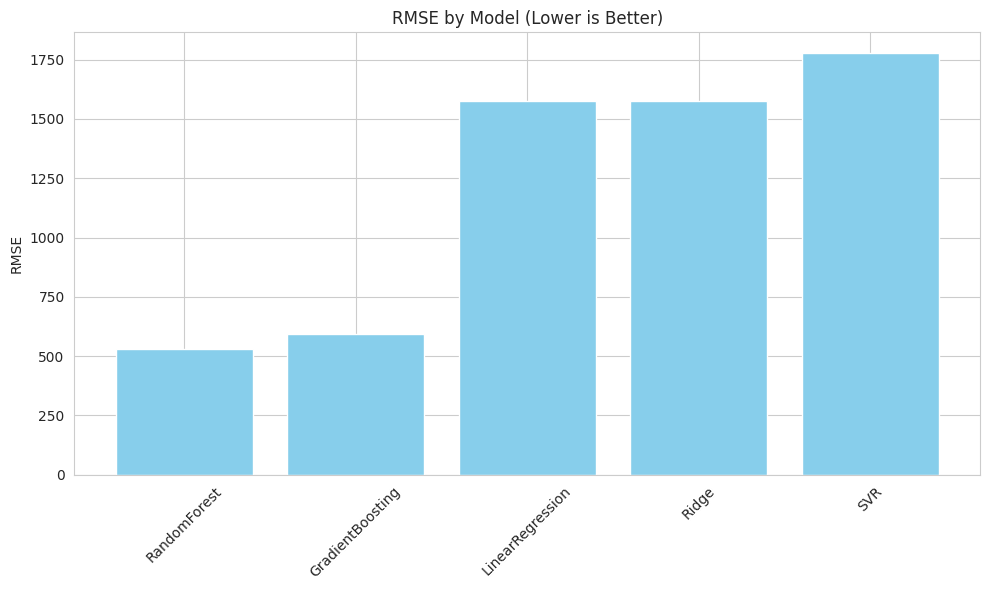

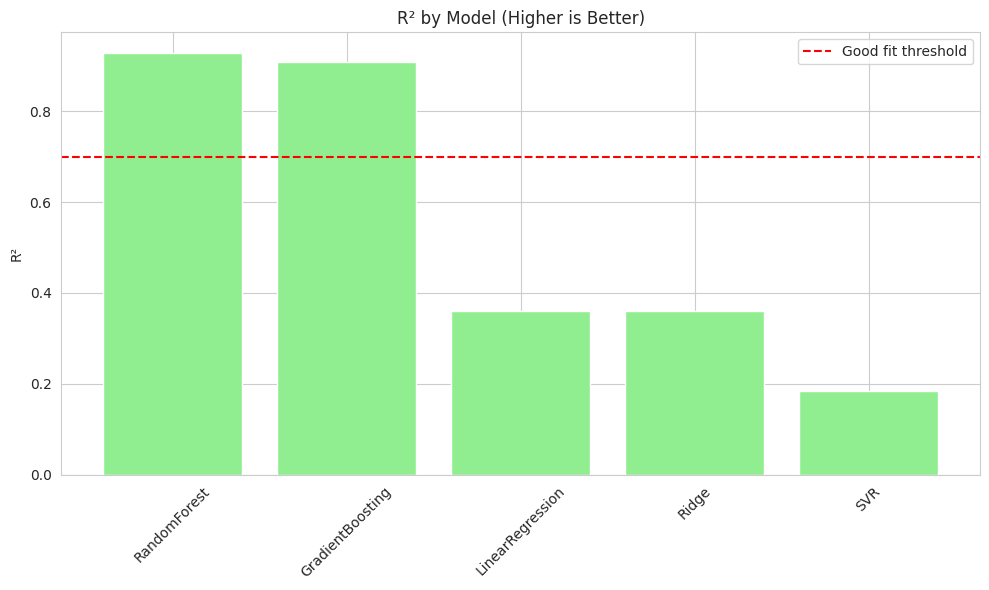

In [ ]:
# Plot RMSE comparison
plt.figure(figsize=(10, 6))
plt.bar(results_df.index, results_df['RMSE'], color='skyblue')
plt.title('RMSE by Model (Lower is Better)')
plt.ylabel('RMSE')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot R² comparison
plt.figure(figsize=(10, 6))
plt.bar(results_df.index, results_df['R²'], color='lightgreen')
plt.title('R² by Model (Higher is Better)')
plt.ylabel('R²')
plt.xticks(rotation=45)
plt.axhline(y=0.7, color='r', linestyle='--', label='Good fit threshold')
plt.legend()
plt.tight_layout()
plt.show()

#### 10. Hyperparameter Tuning for the Best Model Only

In [ ]:
# Define parameter grids for models you might want to tune
# Keys MUST match the keys in the 'models' dictionary from Step 6
# Keep grids defined for potential best models
param_grids = {
    'RandomForest': {
        'regressor__n_estimators': [100, 200],
        'regressor__max_depth': [10, 20, None],
        'regressor__min_samples_split': [2, 5]
    },
    'GradientBoosting': {
        'regressor__n_estimators': [100, 200],
        'regressor__learning_rate': [0.05, 0.1],
        'regressor__max_depth': [3, 5]
    },
    'Ridge': {
        'regressor__alpha': [0.1, 1.0, 10.0, 100.0]
    },
    'SVR': {
        'regressor__C': [0.1, 1, 10],
        'regressor__gamma': ['scale', 'auto'],
        'regressor__kernel': ['rbf', 'linear']
    }
}

# --- Tuning only the best model identified in Step 7 ---

print(
    f"--- Starting Hyperparameter Tuning for the Best Model: "
    f"{best_model} ---"
)

# Check if a parameter grid is defined for the identified best model
if best_model in param_grids:
    print(f"\n🔍 Tuning hyperparameters for {best_model}...")
    start_time = time.time()

    # Get the specific pipeline and grid for the best model
    pipeline_to_tune = pipelines[best_model]
    grid_to_use = param_grids[best_model]

    # Setup GridSearchCV
    grid_search = GridSearchCV(
        pipeline_to_tune,
        grid_to_use,
        cv=3, # 3-fold cross-validation
        scoring='neg_root_mean_squared_error', # Minimize RMSE
        n_jobs=-1, # Use all CPU cores
        verbose=1 # Show progress
    )

    # Fit GridSearchCV to the training data
    # This finds the best parameters and refits the model on the whole train set
    grid_search.fit(X_train, y_train)

    end_time = time.time()
    tuning_time = end_time - start_time

    # The best estimator (refitted pipeline with best params)
    best_tuned_pipeline = grid_search.best_estimator_

    # Get results
    best_params = grid_search.best_params_
    best_cv_rmse = -grid_search.best_score_ # Convert back to positive RMSE

    print(f"\n✓ Best parameters found for {best_model}: {best_params}")
    print(f"✓ Best Cross-Validated RMSE for {best_model}: {best_cv_rmse:.2f}")
    print(f"✓ Tuning duration for {best_model}: {tuning_time:.2f} seconds")

    # Save the best *tuned* pipeline

    model_dir = '../models'
    os.makedirs(model_dir, exist_ok=True)
    tuned_model_filename = f'traffic_prediction_{best_model}_tuned.pkl'
    tuned_model_path = os.path.join(model_dir, tuned_model_filename)

    try:
        joblib.dump(best_tuned_pipeline, tuned_model_path)
        print(
        f"\n💾 Best tuned model ({best_model}) "
        f"saved successfully to: {tuned_model_path}"
        )
    except Exception as e:
        print(f"\nError saving the tuned model pipeline: {e}")

    # Informative: Evaluate this tuned model on the test set
    print(f"\nEvaluating tuned {best_model} on the test set...")
    y_pred_tuned = best_tuned_pipeline.predict(X_test)
    rmse_tuned = np.sqrt(mean_squared_error(y_test, y_pred_tuned))
    r2_tuned = r2_score(y_test, y_pred_tuned)
    print(f" Tuned {best_model} Test RMSE: {rmse_tuned:.2f}")
    print(f" Tuned {best_model} Test R²: {r2_tuned:.3f}")

else:
    # If no grid was defined for the best model
    print(
        f"\n⏭️ No parameter grid defined for the best model ({best_model}). "
        "Skipping tuning."
    )

    print(
        f"   The untuned version of {best_model} "
        f"(saved as traffic_prediction_{best_model}.pkl in Step 8) "
        "is considered the final one."
    )
    # Assign the untuned pipeline to best_tuned_pipeline
    best_tuned_pipeline = pipelines[best_model]


print("\n--- Hyperparameter Tuning Finished ---")

--- Starting Hyperparameter Tuning for the Best Model: RandomForest ---

🔍 Tuning hyperparameters for RandomForest...
Fitting 3 folds for each of 12 candidates, totalling 36 fits

✓ Best parameters found for RandomForest: {'regressor__max_depth': 10, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 200}
✓ Best Cross-Validated RMSE for RandomForest: 505.41
✓ Tuning duration for RandomForest: 158.49 seconds

💾 Best tuned model (RandomForest) saved successfully to: ../models/traffic_prediction_RandomForest_tuned.pkl

Evaluating tuned RandomForest on the test set...
 Tuned RandomForest Test RMSE: 528.44
 Tuned RandomForest Test R²: 0.928

--- Hyperparameter Tuning Finished ---


Exception ignored in: <function ResourceTracker.__del__ at 0x7f93cea58900>
Traceback (most recent call last):
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x7f70a7b58900>
Traceback (most recent call last):
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x7f3fef064900>
Traceback (most recent call last):
  File "/usr/lib64/python3.13/multip